# Gift Card Analysis

## I. Import libraries and datasets

In [133]:
import warnings
import itertools
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib as mpl

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter
import re
import scipy.stats as stats
from scipy.stats import norm
import pylab as pl
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA


%matplotlib inline

In [19]:
giftcard = pd.read_csv('../Jupyter/giftcard_data.csv')
giftcard_sales = pd.read_csv('../Jupyter/giftcard_sales.csv')
giftcard_sales_q4_2016 = pd.read_csv('../Jupyter/giftcard_sales_Q4_2016.csv')

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

giftcard_all = pd.read_csv('../Jupyter/gift_card_all.csv')

## II. Data Cleaning & Feature Engineering

In [160]:
#dates_input = df["month_15"].values.astype('datetime64[D]')

to = giftcard_sales['gc_created_at'].astype('datetime64[D]')
fr = giftcard_sales['gc_redeemed_at'].astype('datetime64[D]')
giftcard_sales['avg_days_to_redemption'] = ((fr-to).dt.total_seconds()/(24 * 60 * 60))+1

to = giftcard_sales['gc_created_at'].astype('datetime64[D]')
fr = giftcard_sales['order_date'].astype('datetime64[D]')
giftcard_sales['avg_days_to_order'] = ((fr-to).dt.total_seconds()/(24 * 60 * 60))+1

giftcard_sales_first_purchase = giftcard_sales[giftcard_sales.order_rk == 1]

to = giftcard_sales_q4_2016['gc_created_at'].astype('datetime64[D]')
fr = giftcard_sales_q4_2016['gc_redeemed_at'].astype('datetime64[D]')
giftcard_sales_q4_2016['avg_days_to_redemption'] = ((fr-to).dt.total_seconds()/(24 * 60 * 60))+1

to = giftcard_sales_q4_2016['gc_created_at'].astype('datetime64[D]')
fr = giftcard_sales_q4_2016['order_date'].astype('datetime64[D]')
giftcard_sales_q4_2016['avg_days_to_order'] = ((fr-to).dt.total_seconds()/(24 * 60 * 60))+1

giftcard_sales_first_purchase_q4_2016 = giftcard_sales_q4_2016[giftcard_sales_q4_2016.order_rk == 1]

# giftcard_all.month_year = pd.to_datetime(giftcard_all['month_year'],format='%Y-%m-%d')
# giftcard_all.gc_created_at = pd.to_datetime(giftcard_all['month_year'],format='%Y-%m-%d')
# giftcard_all.gc_redeemed_at = pd.to_datetime(giftcard_all['gc_redeemed_at'],format='%Y-%m-%d')

In [161]:
giftcard_all['month_year'] = giftcard_all.month_year.dt.to_period('M')
giftcard_all['giftcard_amount_group'] = giftcard_all.gc_amount.astype(int)

AttributeError: 'PeriodProperties' object has no attribute 'to_period'

In [22]:
#RESAMPLING CODE IF NEEDED
#giftcard_sales['order_date'] = pd.to_datetime(giftcard_sales['order_date'], format='%Y-%M-%d')
#mask = (giftcard_sales['order_date'] > '2016-11-01') & (giftcard_sales['order_date'] <= '2017-11-09')
#giftcard_sales_ytd = giftcard_sales.loc[mask]
# giftcard_all.index = giftcard_all['gc_created_at'] 
# giftcard_all.resample('D').sum()

In [23]:
# GROUPBY CODE IF NEEDED
# giftcard_all_grouped = giftcard_all.groupby(['month_year','giftcard_amount_group']).sum()
# giftcard_all_grouped.to_csv('../Jupyter/gift_card_all_grouped.csv')

In [24]:
giftcard['counter'] = 1 #adding a counter column for cumulative sum 

In [162]:
#creating version of giftcard dataframe to remove 0 and NaN
giftcard_df_clean = giftcard[giftcard!=0] #remove zeroes
giftcard_df_clean = giftcard_df_clean[np.isfinite(giftcard_df_clean['avg_days_to_redemption'])] #remove NaN

giftcard_df_nan = giftcard.replace(0, 99999) #creating version of giftcard dataframe to convert 0 to high integer value

#creating version of order value data without zeros or NaN
giftcard_sales_clean = giftcard_sales_first_purchase[giftcard_sales_first_purchase!=0]
giftcard_sales_clean = giftcard_sales_clean[np.isfinite(giftcard_sales_clean['order_value'])]

In [178]:
giftcard_df_sort = giftcard_df_clean.sort_values(by=['avg_days_to_redemption'])
giftcard_df_sort['cum_sum'] = giftcard_df_sort.counter.cumsum()
giftcard_df_sort['cum_perc'] = 100*giftcard_df_sort.cum_sum/giftcard_df_sort.counter.sum()

giftcard_df_sort_with_nan = giftcard_df_nan.sort_values(by=['avg_days_to_redemption'])
giftcard_df_sort_with_nan['cum_sum'] = giftcard_df_sort_with_nan.counter.cumsum()
giftcard_df_sort_with_nan['cum_perc'] = 100*giftcard_df_sort_with_nan.cum_sum/giftcard_df_sort_with_nan.counter.sum()

giftcard_sales_sort = giftcard_sales_first_purchase.sort_values(by=['avg_days_to_order'])
giftcard_sales_sort['cum_sum'] = giftcard_sales_sort.order_value.cumsum()
giftcard_sales_sort['cum_perc'] = 100*giftcard_sales_sort.cum_sum/giftcard_sales_sort.order_value.sum()

giftcard_sales_sort_q4_2016 = giftcard_sales_first_purchase_q4_2016.sort_values(by=['avg_days_to_order'])
giftcard_sales_sort_q4_2016['cum_sum'] = giftcard_sales_sort_q4_2016.order_value.cumsum()
giftcard_sales_sort_q4_2016['cum_perc'] = 100*giftcard_sales_sort_q4_2016.cum_sum/giftcard_sales_sort_q4_2016.order_value.sum()

giftcard_sales_sort_q4_2016_50_200 = giftcard_sales_first_purchase_q4_2016[(giftcard_sales_sort_q4_2016.gc_amount >49) & (giftcard_sales_sort_q4_2016.gc_amount <201)]
giftcard_sales_sort_q4_2016_50_200 = giftcard_sales_sort_q4_2016_50_200.sort_values(by=['avg_days_to_order'])
giftcard_sales_sort_q4_2016_50_200['cum_sum'] = giftcard_sales_sort_q4_2016_50_200.order_value.cumsum

giftcard_sales_sort_q4_2016_50_200['counter'] = 1
giftcard_sales_sort_q4_2016_50_200 = giftcard_sales_sort_q4_2016_50_200.sort_values(by=['avg_days_to_redemption'])
giftcard_sales_sort_q4_2016_50_200['count_cum_sum'] = giftcard_sales_sort_q4_2016_50_200.counter.cumsum()
giftcard_sales_sort_q4_2016_50_200['count_cum_perc'] = 100*giftcard_sales_sort_q4_2016_50_200.count_cum_sum/giftcard_sales_sort_q4_2016_50_200.counter.sum()


## III. Exploration

### How does gross sales of gift cards look like by gift card amount? 

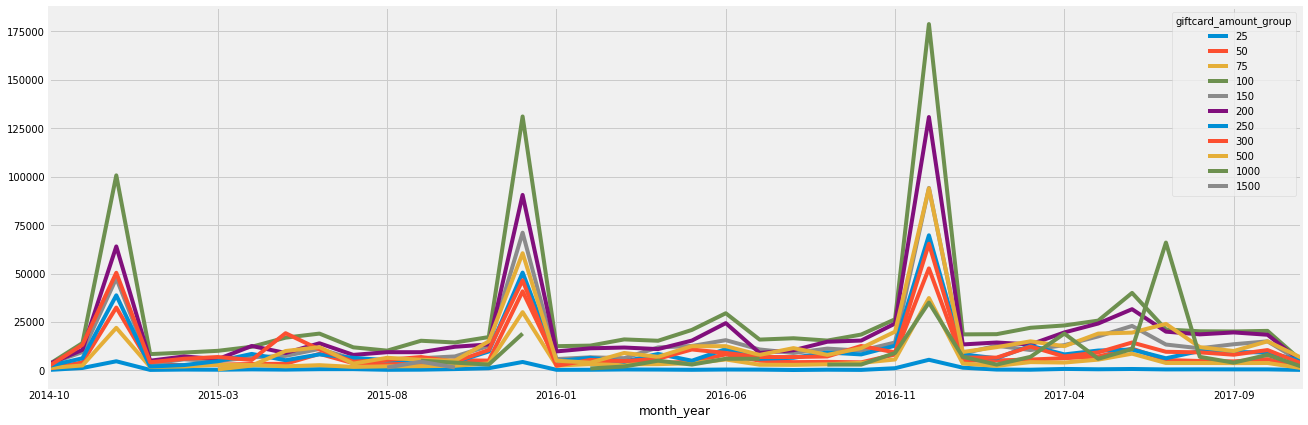

In [27]:
# plot data
fig, ax = plt.subplots(figsize=(20,7))
# use unstack()
giftcard_all.groupby(['month_year','giftcard_amount_group']).sum()['gc_amount'].unstack().plot(ax=ax)
giftcard_all.groupby(['month_year','giftcard_amount_group']).sum()['gc_amount'].unstack().to_csv('../Jupyter/giftcard_all_unstack.csv')

Looks like there is some seasonal spikes in our gift card sales in December each year due to the holidays. 

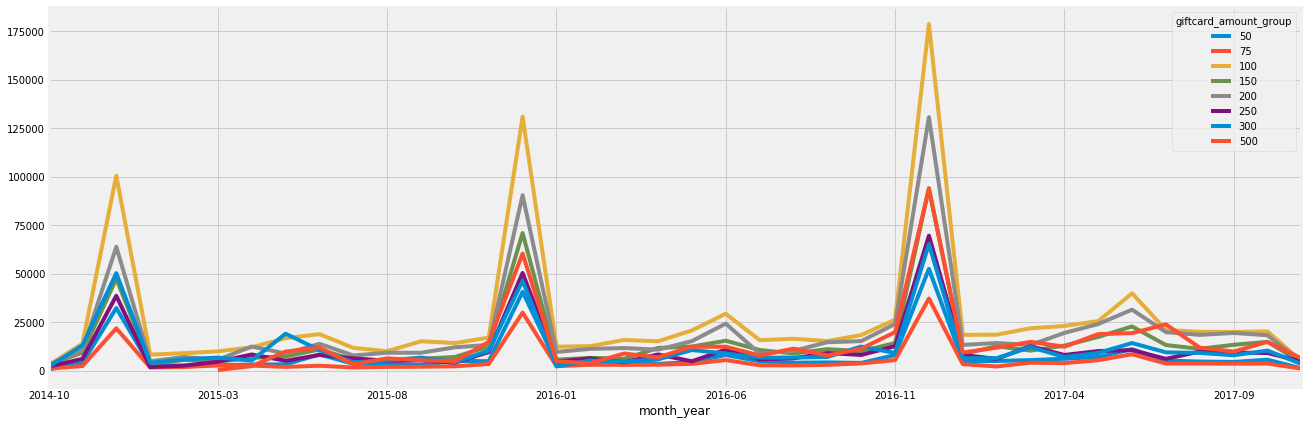

In [28]:
giftcard_all_50_500 = giftcard_all[(giftcard_all['giftcard_amount_group']<501) & (giftcard_all['giftcard_amount_group']>25)]
# plot data
fig, ax = plt.subplots(figsize=(20,7))
# use unstack()
giftcard_all_50_500.groupby(['month_year','giftcard_amount_group']).sum()['gc_amount'].unstack().plot(ax=ax)

In [29]:
giftcard_all_50_500_unstack = giftcard_all_50_500.groupby(['month_year','giftcard_amount_group']).sum()['gc_amount'].unstack().reset_index()

In [30]:
giftcard_all_50_500_unstack.month_year.dtype

dtype('O')

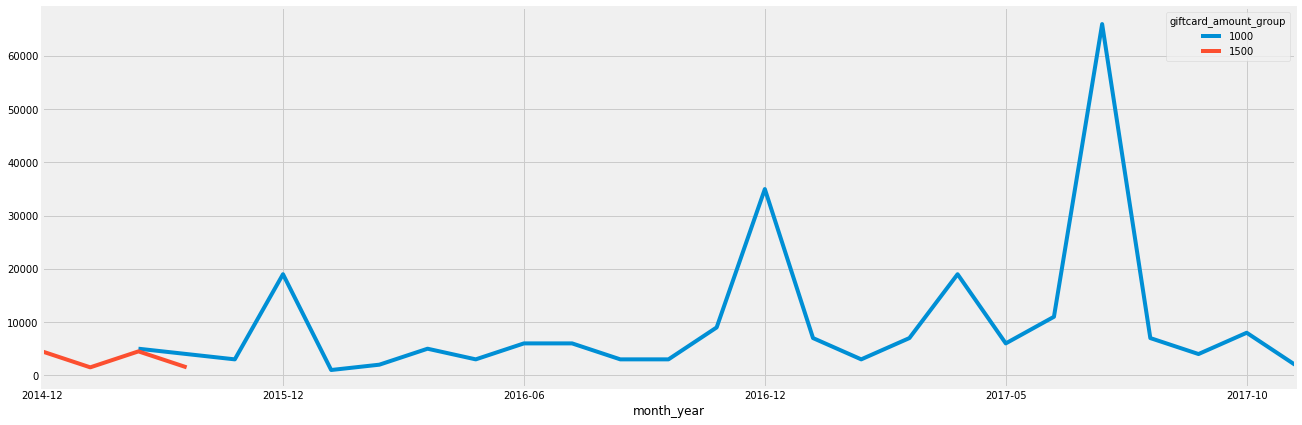

In [31]:
giftcard_all_500 = giftcard_all[(giftcard_all['giftcard_amount_group']>500)]
# plot data
fig, ax = plt.subplots(figsize=(20,7))
# use unstack()
giftcard_all_500.groupby(['month_year','giftcard_amount_group']).sum()['gc_amount'].unstack().plot(ax=ax)

### How many customers using gift cards are new or repeat purchases?

In [32]:
pd.value_counts(giftcard_sales_first_purchase['new_repeat'].values, sort=False)

New        313
Repeat    6329
dtype: int64

#### Within 2017 (YTD), 6,329 are repeat purchases and 313 are new. 

### What's the time period of our analysis?

In [33]:
giftcard_sales.gc_redeemed_at.min()

'2016-11-01 15:35:08.277962'

In [34]:
giftcard_sales.gc_redeemed_at.max()

'2017-11-07 04:43:36.708788'

#### The period of our analysis is between 11/01/16 and 11/07/17.

### What does the distribution of our order values look like?

In [35]:
order_value_sort = giftcard_sales_first_purchase['order_value'].sort_values(ascending=True)
order_value_clean  = order_value_sort[order_value_sort!=0]
fit = stats.norm.pdf(order_value_clean, np.mean(order_value_clean), np.std(order_value_clean))  #this is a fitting indeed

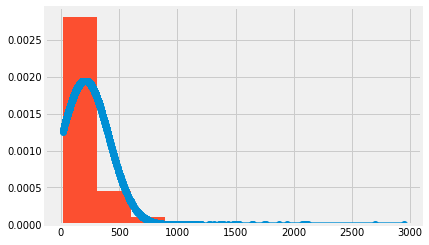

In [36]:
pl.plot(order_value_clean,fit,'-o')
pl.hist(order_value_clean,normed=True)
pl.show() 

## IV. Redemption Rate Analysis
### What percentage of giftcards are redeemed after X days?

In [189]:
redemption_day_sort = giftcard_sales_sort_q4_2016_50_200['avg_days_to_redemption'].sort_values(ascending=True)
redemption_day_clean = redemption_day_sort[redemption_day_sort!=0]
redemption_day_high_int = redemption_day_sort.replace(0, 99999)

In [190]:
def redemption_rate(x):
    return (redemption_day_high_int <= x).astype(float).sum() / (redemption_day_high_int !=0).astype(float).sum() *100

In [191]:
r = {'avg_days_until_redemption':range(30,270,30),'redemption_rate':map(lambda x: redemption_rate(x), range(30,270,30))}
redemption_rate_table = pd.DataFrame(data=r)

In [192]:
redemption_rate_table

,avg_days_until_redemption,redemption_rate
0,30,60.218409
1,60,76.349454
2,90,83.650546
3,120,89.953198
4,150,93.728549
5,180,96.068643
6,210,97.784711
7,240,98.627145


In [188]:
redemption_rate = 1 - ((redemption_day_sort <= 0).astype(float).sum()) / (redemption_day_sort != 0).astype(float).sum()
redemption_rate

0.8294209702660407

#### The overall redemption rate for giftcards is 74.54%

#### The redemption rate for giftcards 30 days out is 50.82%. The redemption rate for giftcards 60 days out is 62.46%. The redemption rate for giftcards 90 days out is 68.27%.

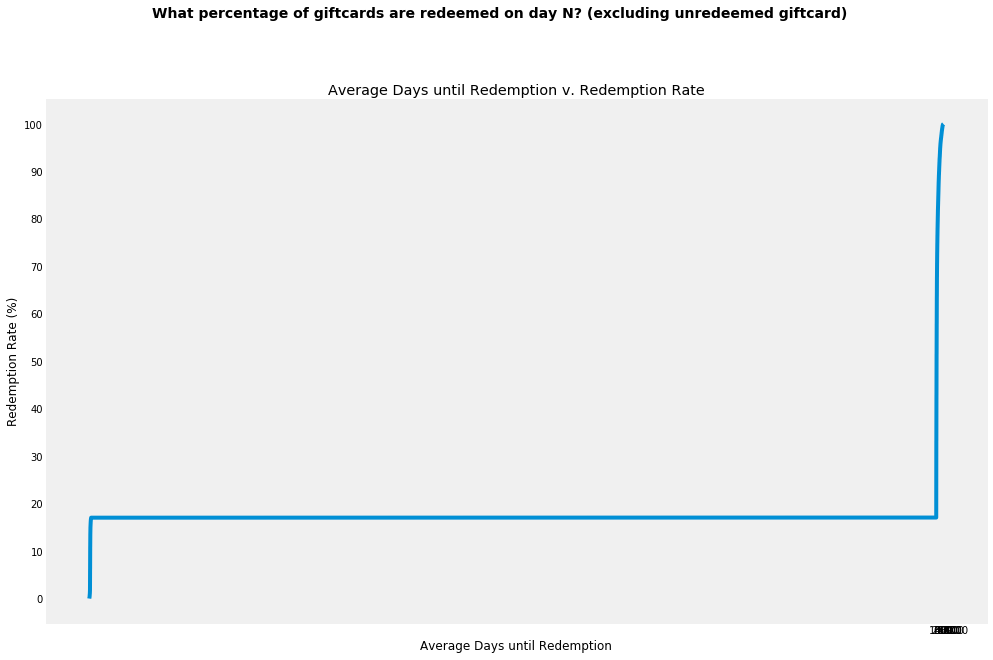

In [42]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('What percentage of giftcards are redeemed on day N? (excluding unredeemed giftcard)', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('Average Days until Redemption v. Redemption Rate')

ax.set_xlabel('Average Days until Redemption')
ax.set_ylabel('Redemption Rate (%)')

ax.set_xticks(np.arange(0, 1100, 100))
ax.set_yticks(np.arange(0, 101, 10))
plt.grid()

#ax.annotate('annotate', xy=(2, 1), xytext=(3, 4),
#            arrowprops=dict(facecolor='black', shrink=0.05))

y = giftcard_df_sort['cum_perc'].astype("float32") #set cumsum to y
x = giftcard_df_sort['avg_days_to_redemption'].astype("int")


plt.plot(x,y)

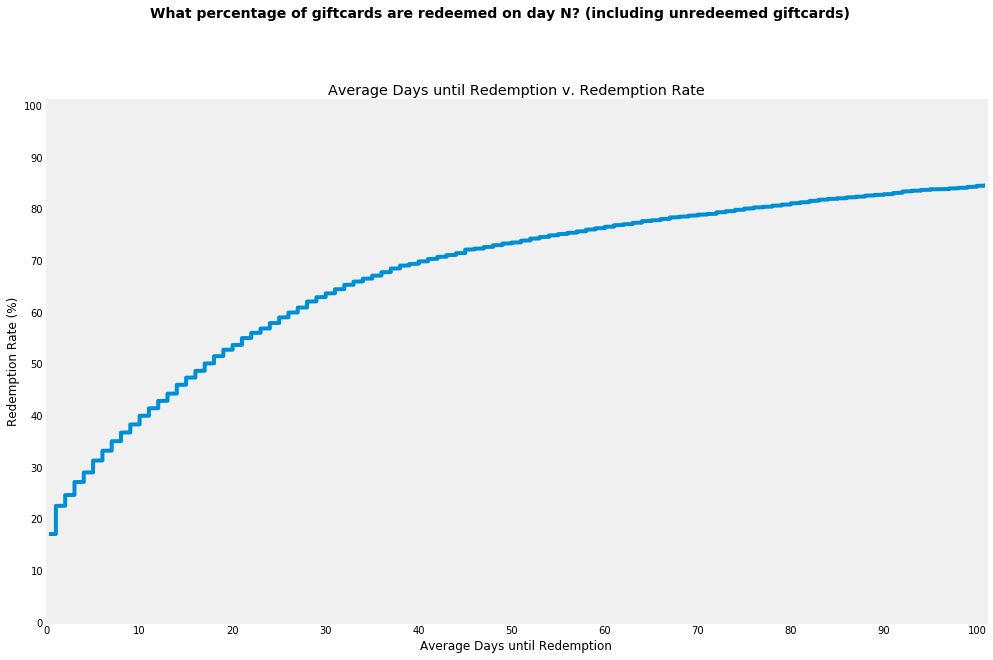

In [43]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('What percentage of giftcards are redeemed on day N? (including unredeemed giftcards)', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('Average Days until Redemption v. Redemption Rate')

ax.set_xlabel('Average Days until Redemption')
ax.set_ylabel('Redemption Rate (%)')

ax.set_xticks(np.arange(0, 101, 10))
ax.set_yticks(np.arange(0, 101, 10))
plt.grid()

ax.set_xlim([0, 101])
ax.set_ylim([0, 101])

#ax.annotate('annotate', xy=(2, 1), xytext=(3, 4),
#            arrowprops=dict(facecolor='black', shrink=0.05))

y = giftcard_df_sort_with_nan['cum_perc'].astype("float32") #set cumsum to y
x = giftcard_df_sort_with_nan['avg_days_to_redemption'].astype("int")


plt.plot(x,y)

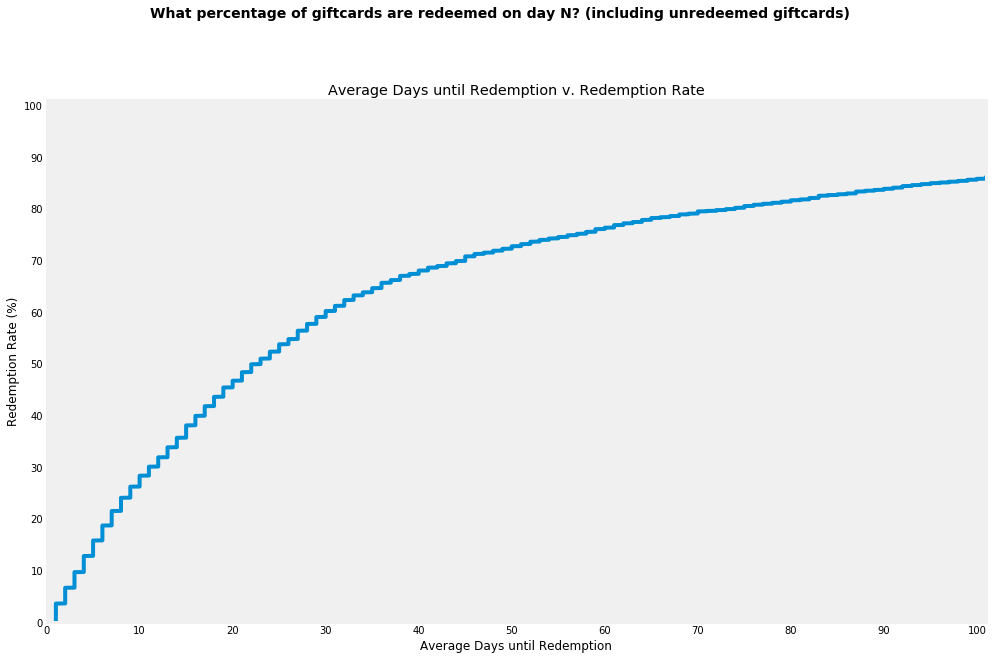

In [179]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('What percentage of giftcards are redeemed on day N? (including unredeemed giftcards)', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('Average Days until Redemption v. Redemption Rate')

ax.set_xlabel('Average Days until Redemption')
ax.set_ylabel('Redemption Rate (%)')

ax.set_xticks(np.arange(0, 101, 10))
ax.set_yticks(np.arange(0, 101, 10))
plt.grid()

ax.set_xlim([0, 101])
ax.set_ylim([0, 101])

#ax.annotate('annotate', xy=(2, 1), xytext=(3, 4),
#            arrowprops=dict(facecolor='black', shrink=0.05))

y = giftcard_sales_sort_q4_2016_50_200['count_cum_perc'].astype("float32") #set cumsum to y
x = giftcard_sales_sort_q4_2016_50_200['avg_days_to_redemption'].astype("int")


plt.plot(x,y)

## V. Gift Card Order Value Analysis

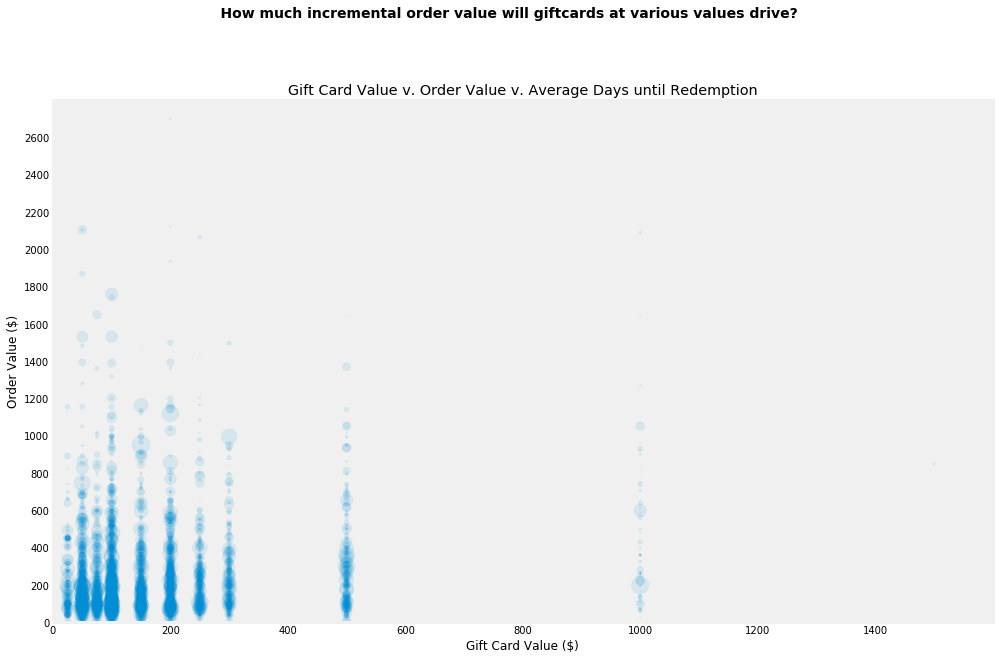

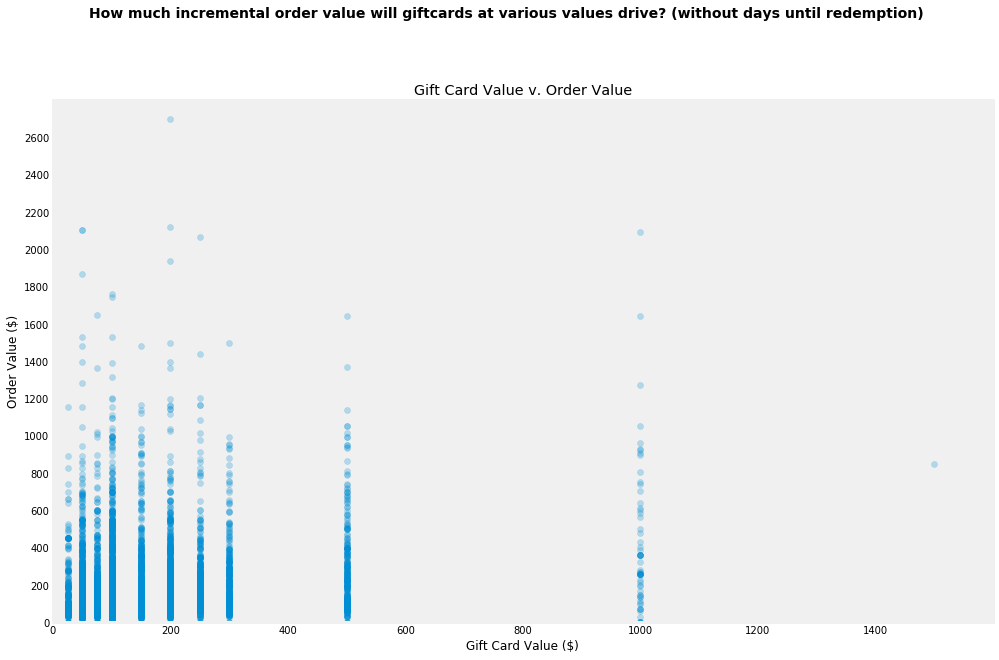

In [44]:
#Gift Card v. Order Value v. Average Days until Redemption
fig = plt.figure(figsize=(15,10))
fig.suptitle('                            How much incremental order value will giftcards at various values drive?                           ', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('Gift Card Value v. Order Value v. Average Days until Redemption')

ax.set_xlabel('Gift Card Value ($)')
ax.set_ylabel('Order Value ($)')

ax.set_xticks(np.arange(0, 1600, 200))
ax.set_yticks(np.arange(0, 2800, 200))
plt.grid()

ax.set_xlim([0, 1600])
ax.set_ylim([0, 2800])

# majorLocator = MultipleLocator(200)
# majorFormatter = FormatStrFormatter('%d')
# minorLocator = MultipleLocator(100)

# ax.yaxis.set_major_locator(majorLocator)
# ax.yaxis.set_major_formatter(majorFormatter)

# ax.xaxis.set_major_locator(majorLocator)
# ax.xaxis.set_major_formatter(majorFormatter)

#for the minor ticks, use no labels; default NullFormatter
#ax.yaxis.set_minor_locator(minorLocator)

x = giftcard_sales_first_purchase.gc_amount
y = giftcard_sales_first_purchase.order_value
area = giftcard_sales_first_purchase.avg_days_to_redemption

plt.scatter(x, y, s=area, alpha=0.1)
plt.show()

#Gift Card v. Order Value v. Average Days until Redemption
fig = plt.figure(figsize=(15,10))
fig.suptitle('How much incremental order value will giftcards at various values drive? (without days until redemption)', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('Gift Card Value v. Order Value')

ax.set_xlabel('Gift Card Value ($)')
ax.set_ylabel('Order Value ($)')

ax.set_xticks(np.arange(0, 1600, 200))
ax.set_yticks(np.arange(0, 2800, 200))
plt.grid()

ax.set_xlim([0, 1600])
ax.set_ylim([0, 2800])

x = giftcard_sales_first_purchase.gc_amount
y = giftcard_sales_first_purchase.order_value
#area = giftcard_sales_first_purchase.avg_days_to_redemption

plt.scatter(x, y, alpha=0.25)
plt.show()

## Identifying the trendline

y=0.278971x+(161.207596)


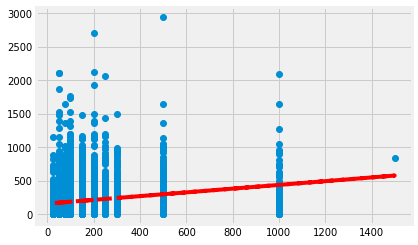

In [45]:
x = giftcard_sales_first_purchase.gc_amount
y = giftcard_sales_first_purchase.order_value

# plot the data itself
pl.plot(x,y,'o')

# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
pl.plot(x,p(x),"r--")
# the line equation:
print "y=%.6fx+(%.6f)"%(z[0],z[1])

### The relationship between order value and giftcard value is y = 0.278971x+(161.207596).

In [46]:
def order_val(x):
    return (0.300576*x)+(149.423483)

In [47]:
d = {'giftcard_val':range(50,1500,50),'order_val':map(lambda x: order_val(x), range(50,1500,50))}

In [48]:
giftcard_order_value_forecast = pd.DataFrame(data=d)
giftcard_order_value_forecast

,giftcard_val,order_val
0,50,164.452283
1,100,179.481083
2,150,194.509883
3,200,209.538683
4,250,224.567483
5,300,239.596283
6,350,254.625083
7,400,269.653883
8,450,284.682683
9,500,299.711483


In [49]:
y = giftcard_sales_first_purchase['order_value']
X = giftcard_sales_first_purchase['gc_amount']
mod = sm.OLS(y,X)
res = mod.fit()
print res.summary()

                            OLS Regression Results                            
Dep. Variable:            order_value   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     3980.
Date:                Tue, 14 Nov 2017   Prob (F-statistic):               0.00
Time:                        09:30:04   Log-Likelihood:                -45511.
No. Observations:                6646   AIC:                         9.102e+04
Df Residuals:                    6645   BIC:                         9.103e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
gc_amount      0.8836      0.014     63.085      0.0

In [50]:
#limit data to show only sales from giftcards redeemed within 90 days 
giftcard_sales_delimit = giftcard_sales_clean[giftcard_sales_clean.avg_days_to_redemption <91]
giftcard_sales_delimit_sort = giftcard_sales_clean.sort_values(by=['gc_redeemed_at'])

### How much revenue can we expect from giftcards N days after a giftcard is purchased?

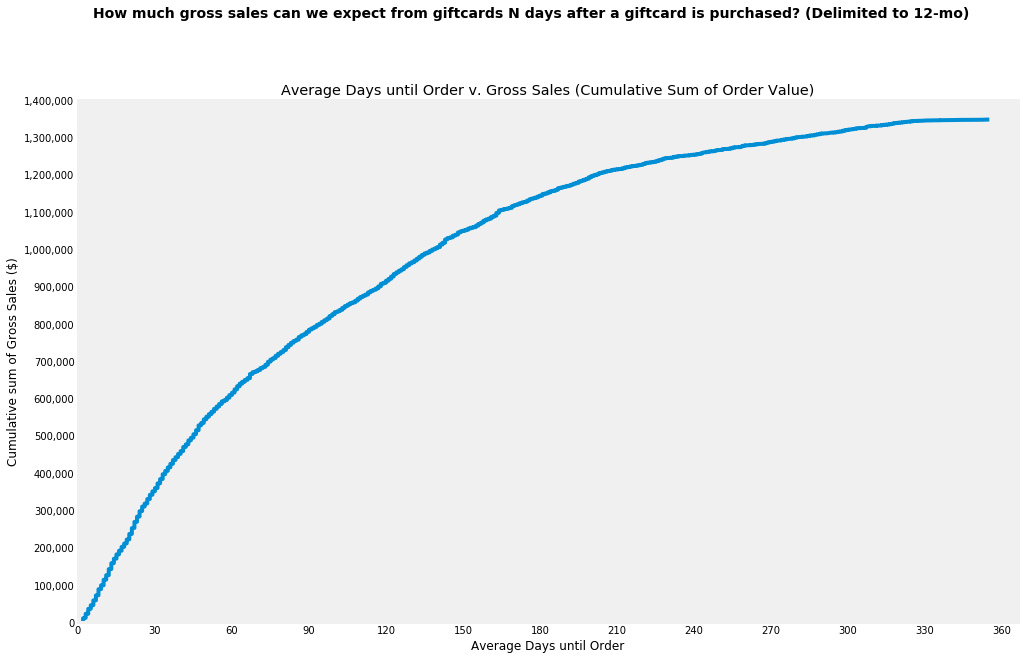

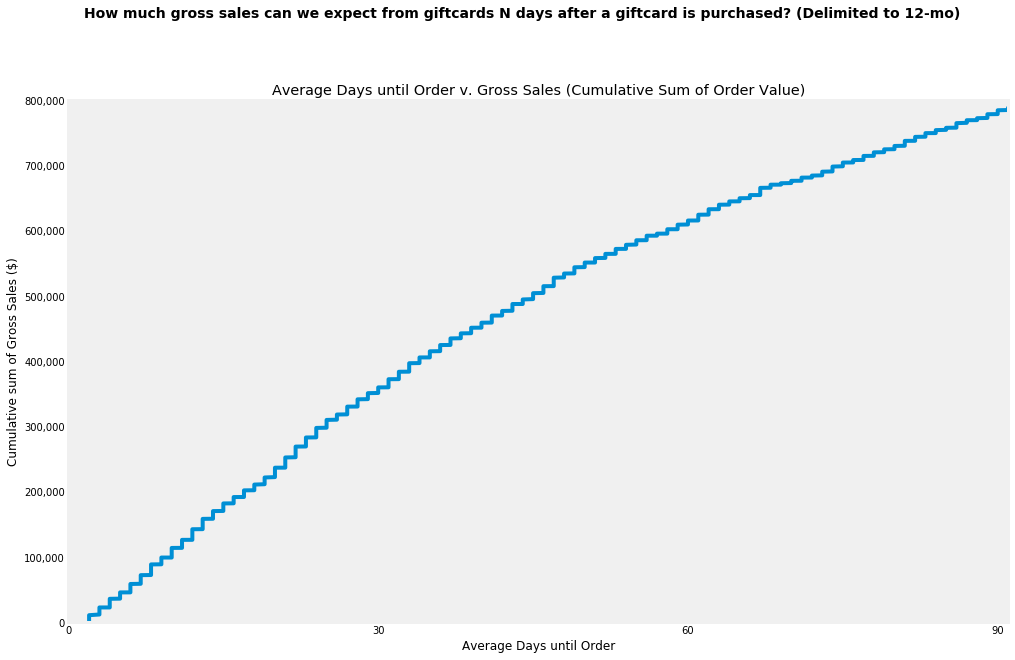

In [51]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('How much gross sales can we expect from giftcards N days after a giftcard is purchased? (Delimited to 12-mo)', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('Average Days until Order v. Gross Sales (Cumulative Sum of Order Value)')

ax.set_xlabel('Average Days until Order')
ax.set_ylabel('Cumulative sum of Gross Sales ($)')

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_xticks(np.arange(0, 366, 30))
ax.set_yticks(np.arange(0, 1400001, 100000))
plt.grid()

ax.set_xlim([0, 366])
ax.set_ylim([0, 1400000])

#ax.annotate('annotate', xy=(2, 1), xytext=(3, 4),
#            arrowprops=dict(facecolor='black', shrink=0.05))

y = giftcard_sales_sort['cum_sum'].astype("float32") #set cumsum to y
x = giftcard_sales_sort['avg_days_to_order'].astype("int")


plt.plot(x,y)

fig = plt.figure(figsize=(15,10))
fig.suptitle('How much gross sales can we expect from giftcards N days after a giftcard is purchased? (Delimited to 12-mo)', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('Average Days until Order v. Gross Sales (Cumulative Sum of Order Value)')

ax.set_xlabel('Average Days until Order')
ax.set_ylabel('Cumulative sum of Gross Sales ($)')

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_xticks(np.arange(0, 91, 30))
ax.set_yticks(np.arange(0, 1400001, 100000))
plt.grid()

ax.set_xlim([0, 91])
ax.set_ylim([0, 800000])

#ax.annotate('annotate', xy=(2, 1), xytext=(3, 4),
#            arrowprops=dict(facecolor='black', shrink=0.05))

y = giftcard_sales_sort['cum_sum'].astype("float32") #set cumsum to y
x = giftcard_sales_sort['avg_days_to_order'].astype("int")


plt.plot(x,y)



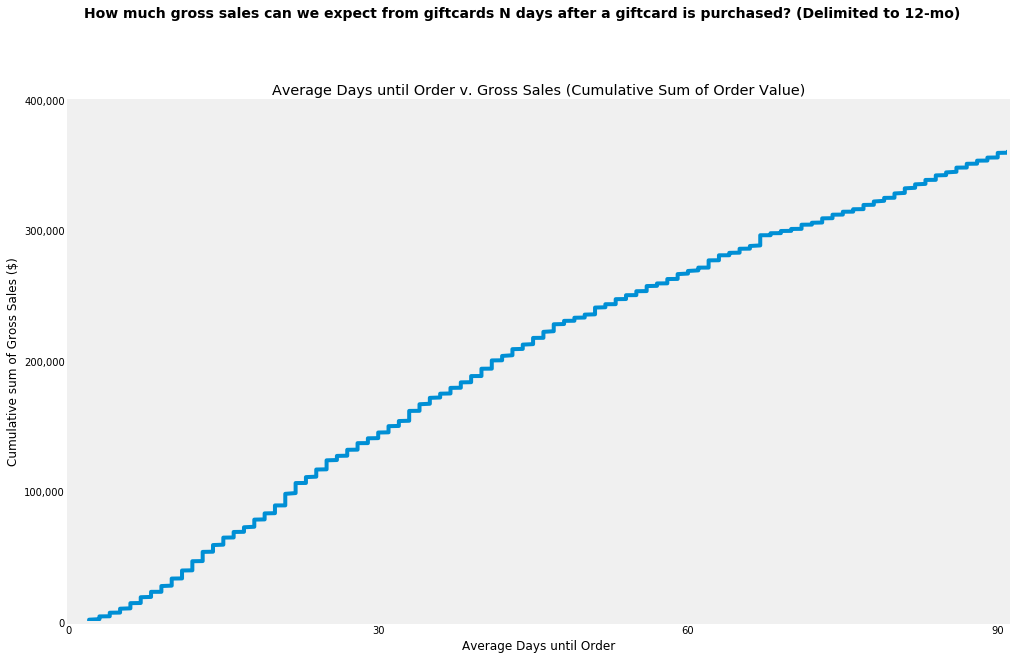

In [52]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('How much gross sales can we expect from giftcards N days after a giftcard is purchased? (Delimited to 12-mo)', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('Average Days until Order v. Gross Sales (Cumulative Sum of Order Value)')

ax.set_xlabel('Average Days until Order')
ax.set_ylabel('Cumulative sum of Gross Sales ($)')

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_xticks(np.arange(0, 91, 30))
ax.set_yticks(np.arange(0, 400001, 100000))
plt.grid()

ax.set_xlim([0, 91])
ax.set_ylim([0, 400000])

#ax.annotate('annotate', xy=(2, 1), xytext=(3, 4),
#            arrowprops=dict(facecolor='black', shrink=0.05))

y = giftcard_sales_sort_q4_2016['cum_sum'].astype("float32") #set cumsum to y
x = giftcard_sales_sort_q4_2016['avg_days_to_order'].astype("int")


plt.plot(x,y)

In [152]:
giftcard_sales_q4_2016_50_200 = giftcard_sales_sort_q4_2016[(giftcard_sales_sort_q4_2016.gc_amount >49) & (giftcard_sales_sort_q4_2016.gc_amount <201)]

In [165]:
giftcard_sales_q4_2016_50_200

,order_id,order_date,redeemer_id,gift_card_id,gc_created_at,gc_redeemed_at,new_repeat,gc_amount,retail_amt,discount_amt,order_value,order_rk,avg_days_to_redemption,avg_days_to_order,cum_sum,cum_perc
10744,307069601,2017-01-16,699325,35324,2017-01-15 14:03:41.322062,2017-01-15 20:54:43.704669,Repeat,200,317.0,126.80,190.20,1,1.0,2.0,190.20,0.023871
2218,306952531,2016-12-12,141980,29059,2016-12-11 14:03:53.610498,2016-12-11 16:33:59.599549,Repeat,200,0.0,0.00,0.00,1,1.0,2.0,190.20,0.023871
4157,306763294,2016-12-19,689129,31047,2016-12-18 00:49:09.359074,2016-12-18 01:32:41.101568,Repeat,200,412.0,123.60,288.40,1,1.0,2.0,1473.80,0.184970
7317,307046150,2017-01-09,618528,35094,2017-01-08 00:42:03.737825,2017-01-08 20:24:40.085394,Repeat,100,88.0,0.00,88.00,1,1.0,2.0,1561.80,0.196015
2648,306772741,2016-11-02,557978,26386,2016-11-01 15:33:03.645174,2016-11-01 15:35:08.277962,Repeat,50,398.0,79.60,318.40,1,1.0,2.0,1880.20,0.235975
7886,307000498,2016-12-26,363266,34323,2016-12-25 16:28:41.518609,2016-12-25 19:43:11.83124,Repeat,100,68.0,20.40,47.60,1,1.0,2.0,1989.40,0.249681
11246,306900187,2016-11-30,390348,27500,2016-11-28 17:28:57.810819,2016-11-28 22:03:59.102133,Repeat,200,30.0,9.00,21.00,1,1.0,3.0,2359.00,0.296068
8937,6370428,2016-12-26,647999,33710,2016-12-24 15:49:59.185776,2016-12-25 18:20:50.447767,Repeat,50,68.0,20.40,47.60,1,2.0,3.0,2406.60,0.302042
7880,307008817,2016-12-27,455139,34230,2016-12-25 13:31:12.0107,2016-12-25 13:44:54.859697,Repeat,50,204.0,0.00,204.00,1,1.0,3.0,2610.60,0.327645
13890,307033858,2017-01-05,264045,34967,2017-01-03 22:13:20.636722,2017-01-04 14:05:59.628318,Repeat,100,500.0,150.00,350.00,1,2.0,3.0,3219.20,0.404027


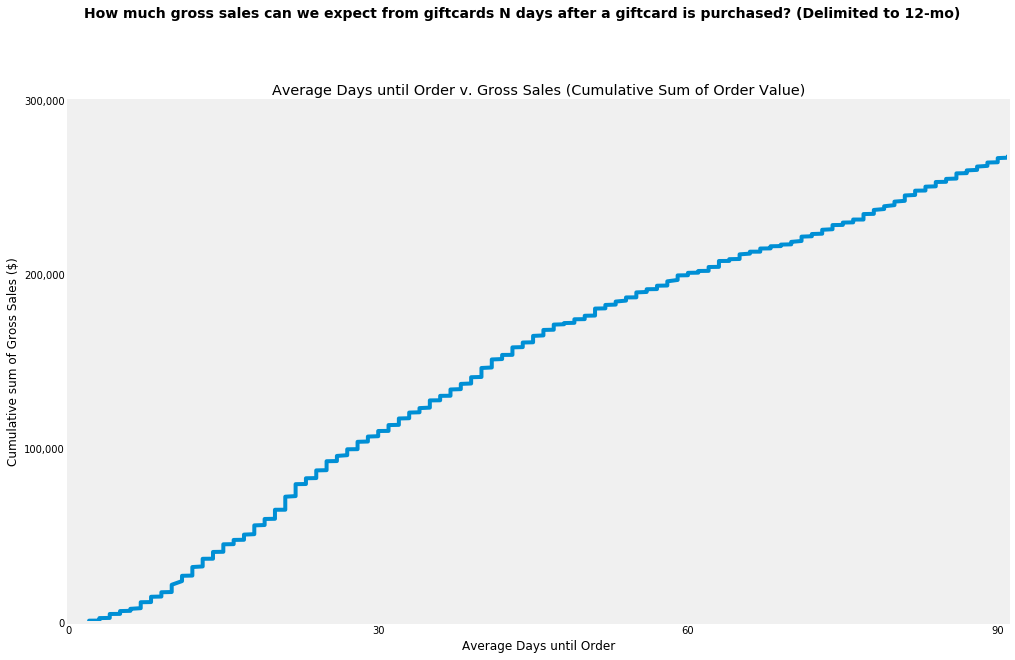

In [171]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('How much gross sales can we expect from giftcards N days after a giftcard is purchased? (Delimited to 12-mo)', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('Average Days until Order v. Gross Sales (Cumulative Sum of Order Value)')

ax.set_xlabel('Average Days until Order')
ax.set_ylabel('Cumulative sum of Gross Sales ($)')

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_xticks(np.arange(0, 91, 30))
ax.set_yticks(np.arange(0, 300001, 100000))
plt.grid()

ax.set_xlim([0, 91])
ax.set_ylim([0, 300000])

#ax.annotate('annotate', xy=(2, 1), xytext=(3, 4),
#            arrowprops=dict(facecolor='black', shrink=0.05))

y = giftcard_sales_sort_q4_2016_50_200['cum_sum'].astype("float32") #set cumsum to y
x = giftcard_sales_sort_q4_2016_50_200['avg_days_to_order'].astype("int")


plt.plot(x,y)

In [168]:
def gross_sales(x):
    return giftcard_sales_q4_2016_50_200[(giftcard_sales_q4_2016_50_200['avg_days_to_order'] <= x)].order_value.sum()
o = {'avg_days_to_order':range(30,270,30),'historical_gross_sales':map(lambda x: gross_sales(x), range(30,270,30))}

In [169]:
historical_gross_sales = pd.DataFrame(data=o)
historical_gross_sales

,avg_days_to_order,historical_gross_sales
0,30,109940.84
1,60,200841.11
2,90,264220.98
3,120,336512.48
4,150,414091.27
5,180,472562.42
6,210,521874.27
7,240,549333.77


In [55]:
y = giftcard_sales_sort_q4_2016['cum_sum']
X = giftcard_sales_sort_q4_2016['avg_days_to_order']
mod = sm.OLS(y,X)
res = mod.fit()
print res.summary()

                            OLS Regression Results                            
Dep. Variable:                cum_sum   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                 1.392e+05
Date:                Tue, 14 Nov 2017   Prob (F-statistic):               0.00
Time:                        09:30:06   Log-Likelihood:                -49618.
No. Observations:                3933   AIC:                         9.924e+04
Df Residuals:                    3932   BIC:                         9.925e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
avg_days_to_order  3148.2069      8.43

#### After running Ordinary Least Squares (OLS) Regression, we're able to achieve an Adj. R-Squared (adjusted correlation coefficient) of 0.973, which means the model explains 97.3% of the variability of the repsonse data around its mean or the model fits our data well. 

## VI. Gift Card Revenue Forecast by Gift Card Value

In [119]:
giftcard_all_unstack = pd.read_csv('../Jupyter/giftcard_all_unstack.csv')
giftcard_all_50_500_unstack = pd.read_csv('../Jupyter/giftcardsales_all_50_500_unstack.csv')

In [120]:
#convert date format
giftcard_all_50_500_unstack.date = pd.to_datetime(giftcard_all_50_500_unstack['date'],format='%Y-%m-%d')

In [121]:
#isolate columns for gift card values
giftcard_all_50_500_50 = giftcard_all_50_500_unstack.iloc[:,[0,1]]
giftcard_all_50_500_75 = giftcard_all_50_500_unstack.iloc[:,[0,2]]
giftcard_all_50_500_100 = giftcard_all_50_500_unstack.iloc[:,[0,3]]
giftcard_all_50_500_150 = giftcard_all_50_500_unstack.iloc[:,[0,4]]
giftcard_all_50_500_200 = giftcard_all_50_500_unstack.iloc[:,[0,5]]
giftcard_all_50_500_250 = giftcard_all_50_500_unstack.iloc[:,[0,6]]
giftcard_all_50_500_300 = giftcard_all_50_500_unstack.iloc[:,[0,7]]
giftcard_all_50_500_500 = giftcard_all_50_500_unstack.iloc[:,[0,8]]

In [124]:
#Set index for dataset
giftcard_all_50_500_50 = giftcard_all_50_500_50.set_index('date')
giftcard_all_50_500_75 = giftcard_all_50_500_75.set_index('date')
giftcard_all_50_500_100 = giftcard_all_50_500_100.set_index('date')
giftcard_all_50_500_150 = giftcard_all_50_500_150.set_index('date')
giftcard_all_50_500_200 = giftcard_all_50_500_200.set_index('date')
giftcard_all_50_500_250 = giftcard_all_50_500_250.set_index('date')
giftcard_all_50_500_300 = giftcard_all_50_500_300.set_index('date')
giftcard_all_50_500_500 = giftcard_all_50_500_500.set_index('date')

In [60]:
ts_50 = giftcard_all_50_500_50['50']
ts_75 = giftcard_all_50_500_75['75']
ts_100 = giftcard_all_50_500_100['100']
ts_150 = giftcard_all_50_500_150['150']
ts_200 = giftcard_all_50_500_200['200']
ts_250 = giftcard_all_50_500_250['250']
ts_300 = giftcard_all_50_500_300['300']
ts_500 = giftcard_all_50_500_500['500']

In [61]:
ts_50

date
2014-10-01      850
2014-11-01     4150
2014-12-01    32450
2015-01-01     2900
2015-02-01     2750
2015-03-01     2950
2015-04-01     3300
2015-05-01     3400
2015-06-01     8550
2015-07-01     3700
2015-08-01     3650
2015-09-01     3150
2015-10-01     5200
2015-11-01     5050
2015-12-01    40800
2016-01-01     4350
2016-02-01     3250
2016-03-01     5100
2016-04-01     3650
2016-05-01     4600
2016-06-01     8250
2016-07-01     5000
2016-08-01     4250
2016-09-01     4400
2016-10-01     4150
2016-11-01     8200
2016-12-01    52650
2017-01-01     5050
2017-02-01     5150
2017-03-01     5600
2017-04-01     6300
2017-05-01     7200
2017-06-01    11250
2017-07-01     5350
2017-08-01     4850
2017-09-01     4650
2017-10-01     5800
2017-11-01     1350
Name: 50, dtype: int64

### Checking Stationarity of a Time Series

In [62]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

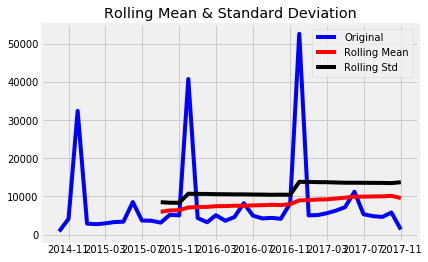

Results of Dickey-Fuller Test:
Test Statistic                -6.261247e+00
p-value                        4.218097e-08
#Lags Used                     0.000000e+00
Number of Observations Used    3.700000e+01
Critical Value (5%)           -2.943539e+00
Critical Value (1%)           -3.620918e+00
Critical Value (10%)          -2.610400e+00
dtype: float64


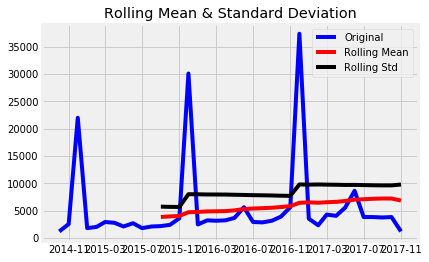

Results of Dickey-Fuller Test:
Test Statistic                -6.256966e+00
p-value                        4.315306e-08
#Lags Used                     0.000000e+00
Number of Observations Used    3.700000e+01
Critical Value (5%)           -2.943539e+00
Critical Value (1%)           -3.620918e+00
Critical Value (10%)          -2.610400e+00
dtype: float64


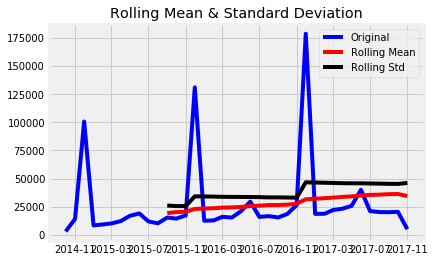

Results of Dickey-Fuller Test:
Test Statistic                -6.308848e+00
p-value                        3.272294e-08
#Lags Used                     0.000000e+00
Number of Observations Used    3.700000e+01
Critical Value (5%)           -2.943539e+00
Critical Value (1%)           -3.620918e+00
Critical Value (10%)          -2.610400e+00
dtype: float64


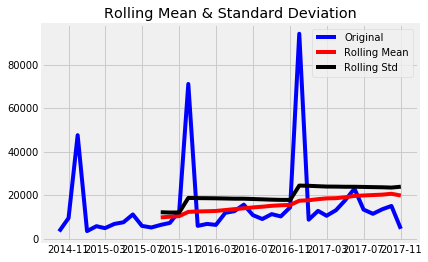

Results of Dickey-Fuller Test:
Test Statistic                -6.289754e+00
p-value                        3.623573e-08
#Lags Used                     0.000000e+00
Number of Observations Used    3.700000e+01
Critical Value (5%)           -2.943539e+00
Critical Value (1%)           -3.620918e+00
Critical Value (10%)          -2.610400e+00
dtype: float64


In [63]:
test_stationarity(ts_50)
test_stationarity(ts_75) 
test_stationarity(ts_100) 
test_stationarity(ts_150) 

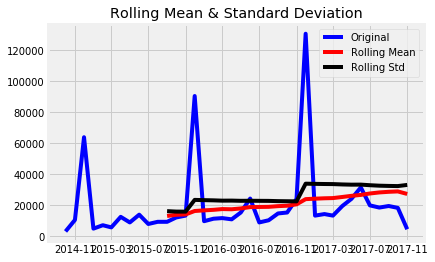

Results of Dickey-Fuller Test:
Test Statistic                -6.141173e+00
p-value                        7.964618e-08
#Lags Used                     0.000000e+00
Number of Observations Used    3.700000e+01
Critical Value (5%)           -2.943539e+00
Critical Value (1%)           -3.620918e+00
Critical Value (10%)          -2.610400e+00
dtype: float64


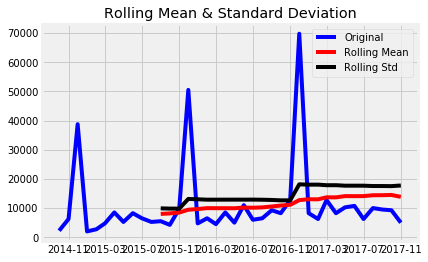

Results of Dickey-Fuller Test:
Test Statistic                -6.181970e+00
p-value                        6.422710e-08
#Lags Used                     0.000000e+00
Number of Observations Used    3.700000e+01
Critical Value (5%)           -2.943539e+00
Critical Value (1%)           -3.620918e+00
Critical Value (10%)          -2.610400e+00
dtype: float64


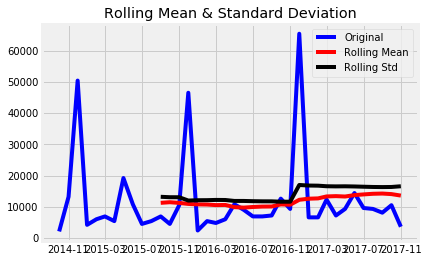

Results of Dickey-Fuller Test:
Test Statistic                -6.504067e+00
p-value                        1.142743e-08
#Lags Used                     0.000000e+00
Number of Observations Used    3.700000e+01
Critical Value (5%)           -2.943539e+00
Critical Value (1%)           -3.620918e+00
Critical Value (10%)          -2.610400e+00
dtype: float64


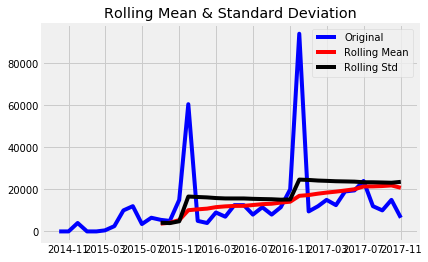

Results of Dickey-Fuller Test:
Test Statistic                 -5.267332
p-value                         0.000006
#Lags Used                      0.000000
Number of Observations Used    37.000000
Critical Value (5%)            -2.943539
Critical Value (1%)            -3.620918
Critical Value (10%)           -2.610400
dtype: float64


In [64]:
test_stationarity(ts_200) 
test_stationarity(ts_250) 
test_stationarity(ts_300) 
test_stationarity(ts_500) 

We can see that the Test Statistic for all gift card values are less than the Critical Values (1-10%). Thus, we can reject the null hypothesis and say that the series is stationary.

### Eliminating Trend & Seasonality

In order to eliminate trend and seasonality, we are taking both the differencing and decomposing approaches.

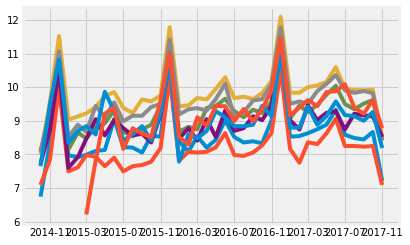

In [65]:
#log transform in order to remove trend
ts_50_log = np.log(ts_50)
ts_75_log = np.log(ts_75)
ts_100_log = np.log(ts_100)
ts_150_log = np.log(ts_150)
ts_200_log = np.log(ts_200)
ts_250_log = np.log(ts_250)
ts_300_log = np.log(ts_300)
ts_500_log = np.log(ts_500)

plt.plot(ts_50_log)
plt.plot(ts_75_log)
plt.plot(ts_100_log)
plt.plot(ts_150_log)
plt.plot(ts_200_log)
plt.plot(ts_250_log)
plt.plot(ts_300_log)
plt.plot(ts_500_log)

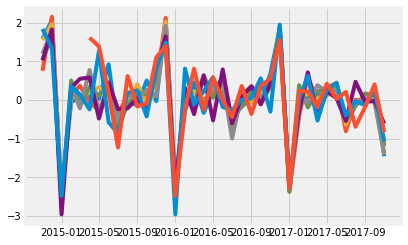

In [66]:
ts_50_log_diff = ts_50_log - ts_50_log.shift()
ts_75_log_diff = ts_75_log - ts_75_log.shift()
ts_100_log_diff = ts_100_log - ts_100_log.shift()
ts_150_log_diff = ts_150_log - ts_150_log.shift()
ts_200_log_diff = ts_200_log - ts_200_log.shift()
ts_250_log_diff = ts_250_log - ts_250_log.shift()
ts_300_log_diff = ts_300_log - ts_300_log.shift()
ts_500_log_diff = ts_500_log - ts_500_log.shift()
plt.plot(ts_50_log_diff)
plt.plot(ts_75_log_diff)
plt.plot(ts_100_log_diff)
plt.plot(ts_150_log_diff)
plt.plot(ts_200_log_diff)
plt.plot(ts_250_log_diff)
plt.plot(ts_300_log_diff)
plt.plot(ts_500_log_diff)

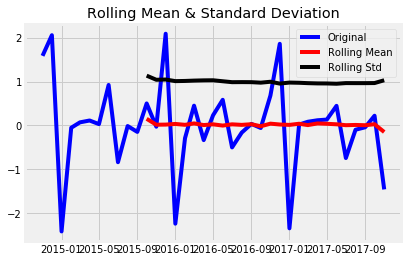

Results of Dickey-Fuller Test:
Test Statistic                 -3.635450
p-value                         0.005118
#Lags Used                     10.000000
Number of Observations Used    26.000000
Critical Value (5%)            -2.981247
Critical Value (1%)            -3.711212
Critical Value (10%)           -2.630095
dtype: float64


In [67]:
ts_50_log_diff.dropna(inplace=True)
ts_75_log_diff.dropna(inplace=True)
ts_100_log_diff.dropna(inplace=True)
ts_150_log_diff.dropna(inplace=True)
ts_200_log_diff.dropna(inplace=True)
ts_250_log_diff.dropna(inplace=True)
ts_300_log_diff.dropna(inplace=True)
ts_500_log_diff = ts_500_log_diff.replace([np.inf, -np.inf],0)
ts_500_log = ts_500_log.replace([np.inf, -np.inf],0)
test_stationarity(ts_50_log_diff)

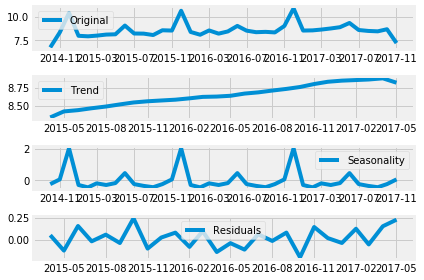

In [68]:
decomposition_50 = seasonal_decompose(ts_50_log)

trend_50 = decomposition_50.trend
seasonal_50 = decomposition_50.seasonal
residual_50 = decomposition_50.resid

plt.subplot(411)
plt.plot(ts_50_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_50, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_50,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_50, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

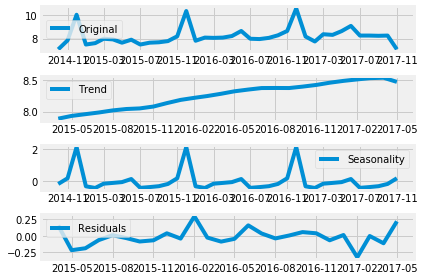

In [69]:
decomposition_75 = seasonal_decompose(ts_75_log)

trend_75 = decomposition_75.trend
seasonal_75 = decomposition_75.seasonal
residual_75 = decomposition_75.resid

plt.subplot(411)
plt.plot(ts_75_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_75, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_75,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_75, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

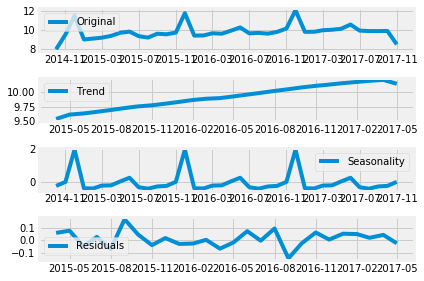

In [70]:
decomposition_100 = seasonal_decompose(ts_100_log)

trend_100 = decomposition_100.trend
seasonal_100 = decomposition_100.seasonal
residual_100 = decomposition_100.resid

plt.subplot(411)
plt.plot(ts_100_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_100, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_100,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_100, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

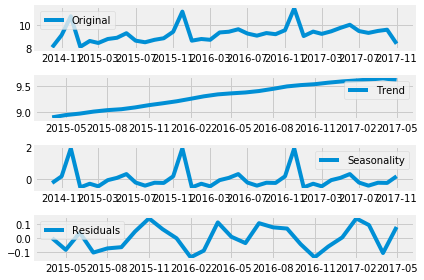

In [71]:
decomposition_150 = seasonal_decompose(ts_150_log)

trend_150 = decomposition_150.trend
seasonal_150 = decomposition_150.seasonal
residual_150 = decomposition_150.resid

plt.subplot(411)
plt.plot(ts_150_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_150, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_150,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_150, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

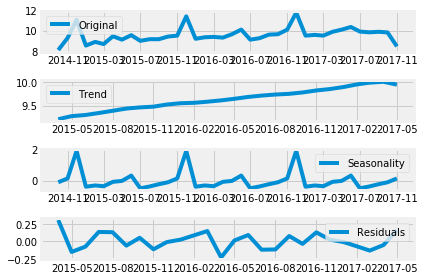

In [72]:
decomposition_200 = seasonal_decompose(ts_200_log)

trend_200 = decomposition_200.trend
seasonal_200 = decomposition_200.seasonal
residual_200 = decomposition_200.resid

plt.subplot(411)
plt.plot(ts_200_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_200, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_200,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_200, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

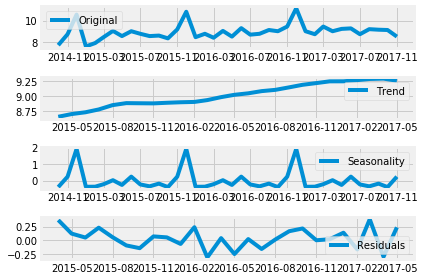

In [73]:
decomposition_250 = seasonal_decompose(ts_250_log)

trend_250 = decomposition_250.trend
seasonal_250 = decomposition_250.seasonal
residual_250 = decomposition_250.resid

plt.subplot(411)
plt.plot(ts_250_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_250, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_250,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_250, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

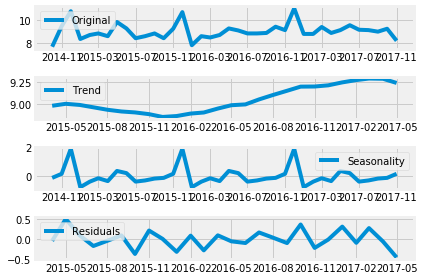

In [74]:
decomposition_300 = seasonal_decompose(ts_300_log)

trend_300 = decomposition_300.trend
seasonal_300 = decomposition_300.seasonal
residual_300 = decomposition_300.resid

plt.subplot(411)
plt.plot(ts_300_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_300, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_300,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_300, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

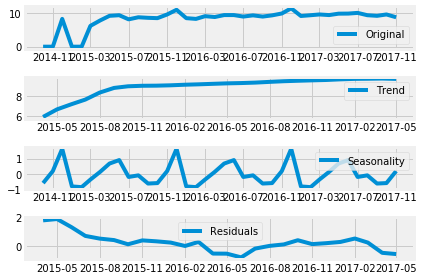

In [75]:
decomposition_500 = seasonal_decompose(ts_500_log)

trend_500 = decomposition_500.trend
seasonal_500 = decomposition_500.seasonal
residual_500 = decomposition_500.resid

plt.subplot(411)
plt.plot(ts_500_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_500, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_500,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_500, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

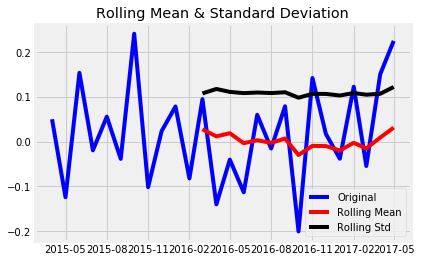

Results of Dickey-Fuller Test:
Test Statistic                -7.126873e+00
p-value                        3.601167e-10
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+01
Critical Value (5%)           -2.986489e+00
Critical Value (1%)           -3.723863e+00
Critical Value (10%)          -2.632800e+00
dtype: float64


In [76]:
ts_50_log_decompose = residual_50
ts_50_log_decompose.dropna(inplace=True)
test_stationarity(ts_50_log_decompose)

### Forecasting a Time Series 

In [77]:
lag_acf_50 = acf(ts_50_log_diff, nlags=12)
lag_pacf_50 = pacf(ts_50_log_diff, nlags=12, method='ols')

lag_acf_75 = acf(ts_75_log_diff, nlags=12)
lag_pacf_75 = pacf(ts_75_log_diff, nlags=12, method='ols')

lag_acf_100 = acf(ts_100_log_diff, nlags=12)
lag_pacf_100 = pacf(ts_100_log_diff, nlags=12, method='ols')

lag_acf_150 = acf(ts_150_log_diff, nlags=12)
lag_pacf_150 = pacf(ts_150_log_diff, nlags=12, method='ols')

lag_acf_200 = acf(ts_200_log_diff, nlags=12)
lag_pacf_200 = pacf(ts_200_log_diff, nlags=12, method='ols')

lag_acf_250 = acf(ts_250_log_diff, nlags=12)
lag_pacf_250 = pacf(ts_250_log_diff, nlags=12, method='ols')

lag_acf_300 = acf(ts_300_log_diff, nlags=12)
lag_pacf_300 = pacf(ts_300_log_diff, nlags=12, method='ols')

lag_acf_500 = acf(ts_500_log_diff, nlags=12)
lag_pacf_500 = pacf(ts_500_log_diff, nlags=12, method='ols')

LinAlgError: SVD did not converge

In [ ]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf_50)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_50_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_50_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf_50)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_50_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_50_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [ ]:
#AR Model
model_AR_50 = ARIMA(ts_50_log, order=(2, 1, 0))  
results_AR_50 = model_AR_50.fit(disp=-1)  
plt.plot(ts_50_log_diff)
plt.plot(results_AR_50.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR_50.fittedvalues-ts_50_log_diff)**2))

In [ ]:
#MA Model
model_MA_50 = ARIMA(ts_50_log, order=(0, 1, 2))  
results_MA_50 = model_MA_50.fit(disp=-1)  
plt.plot(ts_50_log_diff)
plt.plot(results_MA_50.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA_50.fittedvalues-ts_50_log_diff)**2))

In [ ]:
#ARIMA Model (Combined)
model_ARIMA_50 = ARIMA(ts_50_log, order=(2, 1, 2))  
results_ARIMA_50 = model_ARIMA_50.fit(disp=-1)  
plt.plot(ts_50_log_diff)
plt.plot(results_ARIMA_50.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA_50.fittedvalues-ts_50_log_diff)**2))

In [ ]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf_75)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_75_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_75_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf_75)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_75_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_75_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [ ]:
model_ARIMA_75 = ARIMA(ts_75_log, order=(2, 1, 2))  
results_ARIMA_75 = model_ARIMA_75.fit(disp=-1)
plt.plot(ts_75_log_diff)
plt.plot(results_ARIMA_75.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA_75.fittedvalues-ts_75_log_diff)**2))

In [ ]:
model_ARIMA_100 = ARIMA(ts_100_log, order=(2, 1, 2))  
results_ARIMA_100 = model_ARIMA_100.fit(disp=-1)
plt.plot(ts_100_log_diff)
plt.plot(results_ARIMA_100.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA_100.fittedvalues-ts_100_log_diff)**2))

In [78]:
model_ARIMA_150 = ARIMA(ts_150_log, order=(2, 1, 2))  
results_ARIMA_150 = model_ARIMA_150.fit(disp=-1)  

model_ARIMA_200 = ARIMA(ts_200_log, order=(2, 1, 2))  
results_ARIMA_200 = model_ARIMA_200.fit(disp=-1)  

model_ARIMA_250 = ARIMA(ts_250_log, order=(2, 1, 2))  
results_ARIMA_250 = model_ARIMA_250.fit(disp=-1)  

model_ARIMA_300 = ARIMA(ts_300_log, order=(2, 1, 2))  
results_ARIMA_300 = model_ARIMA_300.fit(disp=-1)   

model_ARIMA_500 = ARIMA(ts_500_log, order=(2, 1, 2))  
results_ARIMA_500 = model_ARIMA_500.fit(disp=-1)  

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

In [79]:
predictions_ARIMA_diff_50 = pd.Series(results_ARIMA_50.fittedvalues, copy=True)
predictions_ARIMA_diff_75 = pd.Series(results_ARIMA_75.fittedvalues, copy=True)
predictions_ARIMA_diff_100 = pd.Series(results_ARIMA_100.fittedvalues, copy=True)
predictions_ARIMA_diff_150 = pd.Series(results_ARIMA_150.fittedvalues, copy=True)
predictions_ARIMA_diff_200 = pd.Series(results_ARIMA_200.fittedvalues, copy=True)
predictions_ARIMA_diff_250 = pd.Series(results_ARIMA_250.fittedvalues, copy=True)
predictions_ARIMA_diff_300 = pd.Series(results_ARIMA_300.fittedvalues, copy=True)
predictions_ARIMA_diff_500 = pd.Series(results_ARIMA_500.fittedvalues, copy=True)

NameError: name 'results_ARIMA_50' is not defined

In [80]:
predictions_ARIMA_diff_cumsum_50 = predictions_ARIMA_diff_50.cumsum()
print predictions_ARIMA_diff_cumsum_50.head()

NameError: name 'predictions_ARIMA_diff_50' is not defined

In [81]:
predictions_ARIMA_log_50 = pd.Series(ts_50_log.ix[0], index=ts_50_log.index)
predictions_ARIMA_log_50 = predictions_ARIMA_log_50.add(predictions_ARIMA_diff_cumsum_50,fill_value=0)
predictions_ARIMA_log_50.head()

NameError: name 'predictions_ARIMA_diff_cumsum_50' is not defined

Text(0.5,1,u'RMSE: 12525.6342')

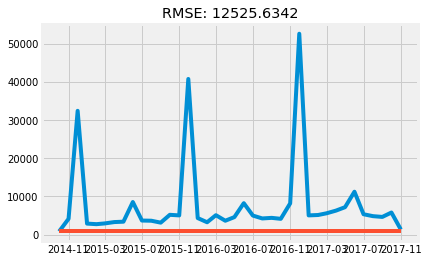

In [82]:
predictions_ARIMA_50 = np.exp(predictions_ARIMA_log_50)
plt.plot(ts_50)
plt.plot(predictions_ARIMA_50)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_50-ts_50)**2)/len(ts_50)))

In [123]:
giftcard_all_50_500_50.dtypes

date    datetime64[ns]
50               int64
dtype: object

In [127]:
ts_50 = ts_50.fillna(ts_50.bfill())
print ts_50

date
2014-10-01      850
2014-11-01     4150
2014-12-01    32450
2015-01-01     2900
2015-02-01     2750
2015-03-01     2950
2015-04-01     3300
2015-05-01     3400
2015-06-01     8550
2015-07-01     3700
2015-08-01     3650
2015-09-01     3150
2015-10-01     5200
2015-11-01     5050
2015-12-01    40800
2016-01-01     4350
2016-02-01     3250
2016-03-01     5100
2016-04-01     3650
2016-05-01     4600
2016-06-01     8250
2016-07-01     5000
2016-08-01     4250
2016-09-01     4400
2016-10-01     4150
2016-11-01     8200
2016-12-01    52650
2017-01-01     5050
2017-02-01     5150
2017-03-01     5600
2017-04-01     6300
2017-05-01     7200
2017-06-01    11250
2017-07-01     5350
2017-08-01     4850
2017-09-01     4650
2017-10-01     5800
2017-11-01     1350
Freq: MS, Name: 50, dtype: int64


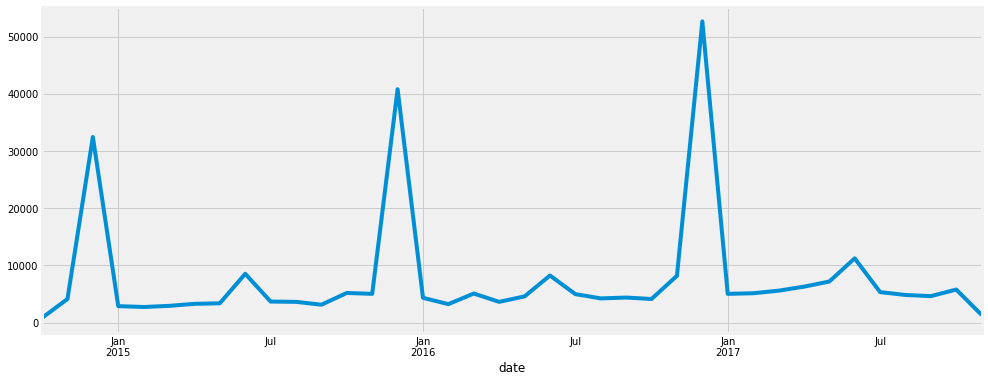

In [128]:
ts_50.plot(figsize=(15, 6))
plt.show()

In [129]:
#new attempt: ARIMA methodology with parameter selection
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

ts_50 = giftcard_all_50_500_50['50'].resample('MS').mean()

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [134]:
#warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(ts_50,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ValueError: Number of states in statespace model must be a positive number.

In [ ]:
#Paused analysis at Parameter Selection due to error in SARIMAX()